<a href="https://colab.research.google.com/github/LeeJeongWoon-Workout/Deep_Learning_Pytorch/blob/main/baseline_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Project

- Type: a competition-based project with a leader board (training datasets is released on lecture's kaggle competition page)

- Objective: maximizing the test accuracy.

- Period:
    - 23th Nov. to 9th Dec.

- Evaluations: Final rank and presentations.

- Additional points
    - (a) All participants are requested to present their methods and release the source codes.
    - (b) The final score should be reproducible by the shared codes.

## CAUTION

- You can change **only** the **[Define Model](#scrollTo=9ViRr0JT84C7)**, **[Train Model](#scrollTo=NSFY5dyOm-qA)** and **[Hyperparameters](#scrollTo=Pv-hIWaJomEf)** sections.
- You can use any kind of deep neural networks and apply any optimization techniques to improve the performance.

In [1]:
# check your GPU device
!nvidia-smi

Thu Nov 25 07:35:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
\
# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [5]:
!unzip '/content/drive/MyDrive/Colab Notebooks/deeplearning/deeplearning2021competition.zip' -d .

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./food_data/processed_images/ravioli/549878.jpg  
  inflating: ./food_data/processed_images/ravioli/552370.jpg  
  inflating: ./food_data/processed_images/ravioli/552676.jpg  
  inflating: ./food_data/processed_images/ravioli/554091.jpg  
  inflating: ./food_data/processed_images/ravioli/557073.jpg  
  inflating: ./food_data/processed_images/ravioli/565182.jpg  
  inflating: ./food_data/processed_images/ravioli/566960.jpg  
  inflating: ./food_data/processed_images/ravioli/568117.jpg  
  inflating: ./food_data/processed_images/ravioli/575206.jpg  
  inflating: ./food_data/processed_images/ravioli/57783.jpg  
  inflating: ./food_data/processed_images/ravioli/578087.jpg  
  inflating: ./food_data/processed_images/ravioli/582472.jpg  
  inflating: ./food_data/processed_images/ravioli/584114.jpg  
  inflating: ./food_data/processed_images/ravioli/586572.jpg  
  inflating: ./food_data/processed_images/ravioli/603051.jpg  
  inflating: ./food_

### mount google drive example

1. Execute the mount cell and click that https URL below picture  
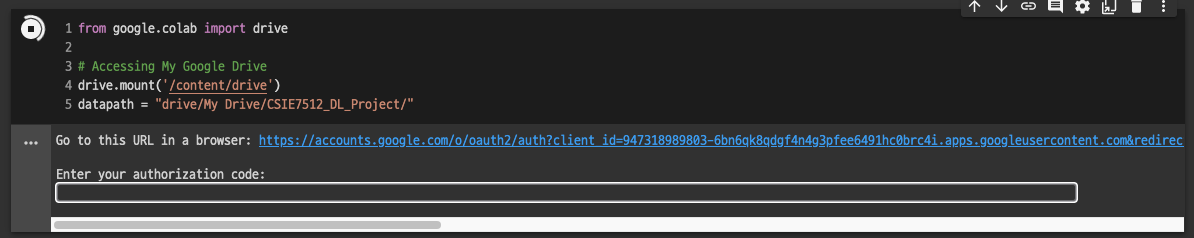

2. Click your account  
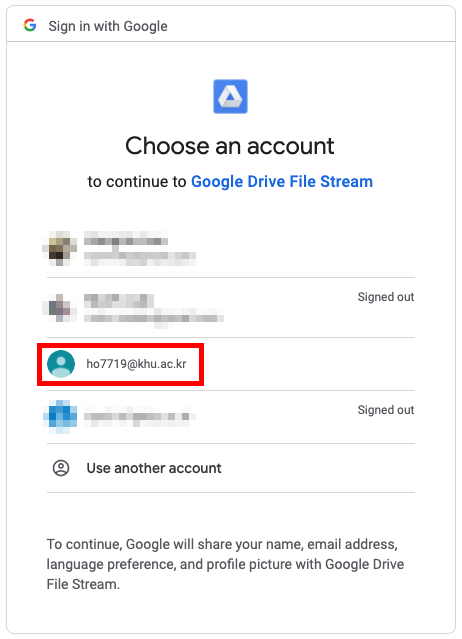

3. Click allow button  
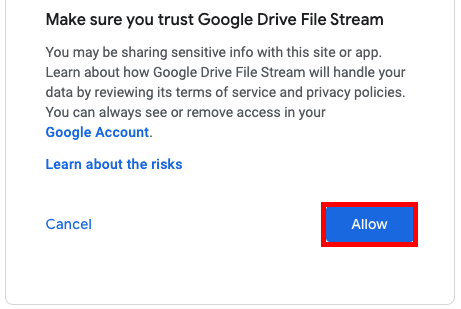

4. Copy the authorization code  
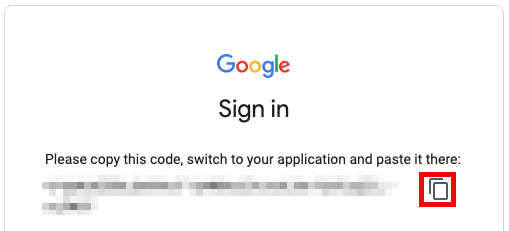


5. Enter the authorization code   
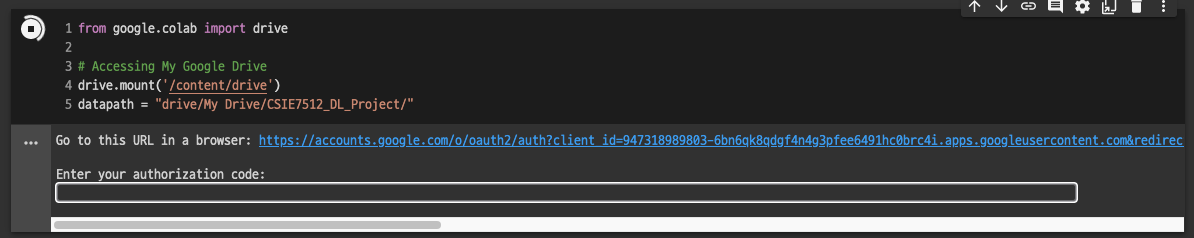

6. Done!  
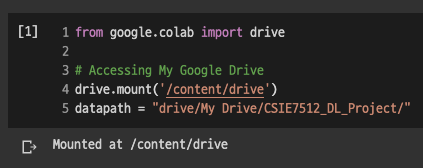

## Unzip dataset on runtime session

## Define Model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
### https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
import torch
import torch.nn as nn
from torch.utils.model_zoo import load_url as load_state_dict_from_url
import time

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

__all__ = ['MobileNetV3', 'mobilenetv3']


def conv_bn(inp, oup, stride, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 3, stride, 1, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


def conv_1x1_bn(inp, oup, conv_layer=nn.Conv2d, norm_layer=nn.BatchNorm2d, nlin_layer=nn.ReLU):
    return nn.Sequential(
        conv_layer(inp, oup, 1, 1, 0, bias=False),
        norm_layer(oup),
        nlin_layer(inplace=True)
    )


class Hswish(nn.Module):
    def __init__(self, inplace=True):
        super(Hswish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return x * F.relu6(x + 3., inplace=self.inplace) / 6.


class Hsigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(Hsigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return F.relu6(x + 3., inplace=self.inplace) / 6.


class SEModule(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            Hsigmoid()
            # nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class Identity(nn.Module):
    def __init__(self, channel):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class MobileBottleneck(nn.Module):
    def __init__(self, inp, oup, kernel, stride, exp, se=False, nl='RE'):
        super(MobileBottleneck, self).__init__()
        assert stride in [1, 2]
        assert kernel in [3, 5]
        padding = (kernel - 1) // 2
        self.use_res_connect = stride == 1 and inp == oup

        conv_layer = nn.Conv2d
        norm_layer = nn.BatchNorm2d
        if nl == 'RE':
            nlin_layer = nn.ReLU # or ReLU6
        elif nl == 'HS':
            nlin_layer = Hswish
        else:
            raise NotImplementedError
        if se:
            SELayer = SEModule
        else:
            SELayer = Identity

        self.conv = nn.Sequential(
            # pw
            conv_layer(inp, exp, 1, 1, 0, bias=False),
            norm_layer(exp),
            nlin_layer(inplace=True),
            # dw
            conv_layer(exp, exp, kernel, stride, padding, groups=exp, bias=False),
            norm_layer(exp),
            SELayer(exp),
            nlin_layer(inplace=True),
            # pw-linear
            conv_layer(exp, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, n_class=90, input_size=224, dropout=0.8, mode='small', width_mult=1.0):
        super(MobileNetV3, self).__init__()
        input_channel = 16
        last_channel = 1280
        if mode == 'large':
            # refer to Table 1 in paper
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16,  16,  False, 'RE', 1],
                [3, 64,  24,  False, 'RE', 2],
                [3, 72,  24,  False, 'RE', 1],
                [5, 72,  40,  True,  'RE', 2],
                [5, 120, 40,  True,  'RE', 1],
                [5, 120, 40,  True,  'RE', 1],
                [3, 240, 80,  False, 'HS', 2],
                [3, 200, 80,  False, 'HS', 1],
                [3, 184, 80,  False, 'HS', 1],
                [3, 184, 80,  False, 'HS', 1],
                [3, 480, 112, True,  'HS', 1],
                [3, 672, 112, True,  'HS', 1],
                [5, 672, 160, True,  'HS', 2],
                [5, 960, 160, True,  'HS', 1],
                [5, 960, 160, True,  'HS', 1],
            ]
        elif mode == 'small':
            # refer to Table 2 in paper
            mobile_setting = [
                # k, exp, c,  se,     nl,  s,
                [3, 16,  16,  True,  'RE', 2],
                [3, 72,  24,  False, 'RE', 2],
                [3, 88,  24,  False, 'RE', 1],
                [5, 96,  40,  True,  'HS', 2],
                [5, 240, 40,  True,  'HS', 1],
                [5, 240, 40,  True,  'HS', 1],
                [5, 120, 48,  True,  'HS', 1],
                [5, 144, 48,  True,  'HS', 1],
                [5, 288, 96,  True,  'HS', 2],
                [5, 576, 96,  True,  'HS', 1],
                [5, 576, 96,  True,  'HS', 1],
            ]
        else:
            raise NotImplementedError

        # building first layer
        assert input_size % 32 == 0
        last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2, nlin_layer=Hswish)]
        self.classifier = []

        # building mobile blocks
        for k, exp, c, se, nl, s in mobile_setting:
            output_channel = make_divisible(c * width_mult)
            exp_channel = make_divisible(exp * width_mult)
            self.features.append(MobileBottleneck(input_channel, output_channel, k, s, exp_channel, se, nl))
            input_channel = output_channel

        # building last several layers
        if mode == 'large':
            last_conv = make_divisible(960 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        elif mode == 'small':
            last_conv = make_divisible(576 * width_mult)
            self.features.append(conv_1x1_bn(input_channel, last_conv, nlin_layer=Hswish))
            # self.features.append(SEModule(last_conv))  # refer to paper Table2, but I think this is a mistake
            self.features.append(nn.AdaptiveAvgPool2d(1))
            self.features.append(nn.Conv2d(last_conv, last_channel, 1, 1, 0))
            self.features.append(Hswish(inplace=True))
        else:
            raise NotImplementedError

        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),    # refer to paper section 6
            nn.Linear(last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


def mobilenetv3(pretrained=False, **kwargs):
    model = MobileNetV3(**kwargs)
    if pretrained:
        state_dict = torch.load('mobilenetv3_small_67.4.pth.tar')
        model.load_state_dict(state_dict, strict=True)
        # raise NotImplementedError
    return model

In [ ]:
"""
Creates a EfficientNetV2 Model as defined in:
Mingxing Tan, Quoc V. Le. (2021). 
EfficientNetV2: Smaller Models and Faster Training
arXiv preprint arXiv:2104.00298.
import from https://github.com/d-li14/mobilenetv2.pytorch
"""

import torch
import torch.nn as nn
import math

__all__ = ['effnetv2_s', 'effnetv2_m', 'effnetv2_l', 'effnetv2_xl']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# SiLU (Swish) activation function
if hasattr(nn, 'SiLU'):
    SiLU = nn.SiLU
else:
    # For compatibility with old PyTorch versions
    class SiLU(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)

 
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                SiLU(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                SELayer(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                nn.Conv2d(inp, hidden_dim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EffNetV2(nn.Module):
    def __init__(self, cfgs, num_classes=90, width_mult=1.):
        super(EffNetV2, self).__init__()
        self.cfgs = cfgs

        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1792 * width_mult, 8) if width_mult > 1.0 else 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.001)
                m.bias.data.zero_()


def effnetv2_s(**kwargs):
    """
    Constructs a EfficientNetV2-S model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  2, 1, 0],
        [4,  48,  4, 2, 0],
        [4,  64,  4, 2, 0],
        [4, 128,  6, 2, 1],
        [6, 160,  9, 1, 1],
        [6, 256, 15, 2, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_m(**kwargs):
    """
    Constructs a EfficientNetV2-M model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  3, 1, 0],
        [4,  48,  5, 2, 0],
        [4,  80,  5, 2, 0],
        [4, 160,  7, 2, 1],
        [6, 176, 14, 1, 1],
        [6, 304, 18, 2, 1],
        [6, 512,  5, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_l(**kwargs):
    """
    Constructs a EfficientNetV2-L model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  7, 2, 0],
        [4,  96,  7, 2, 0],
        [4, 192, 10, 2, 1],
        [6, 224, 19, 1, 1],
        [6, 384, 25, 2, 1],
        [6, 640,  7, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_xl(**kwargs):
    """
    Constructs a EfficientNetV2-XL model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  8, 2, 0],
        [4,  96,  8, 2, 0],
        [4, 192, 16, 2, 1],
        [6, 256, 24, 1, 1],
        [6, 512, 32, 2, 1],
        [6, 640,  8, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)

## utils

In [16]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [17]:
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
from PIL import Image

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")

from PIL import Image
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

def default_loader(path: str) -> Any:
    from torchvision import get_image_backend

    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)

class FoodImageFolder(torchvision.datasets.DatasetFolder):
    """A generic data loader where the images are arranged in this way by default: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/[...]/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/[...]/asd932_.png
    This class inherits from :class:`~torchvision.datasets.DatasetFolder` so
    the same methods can be overridden to customize the dataset.
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        loader: Callable[[str], Any] = default_loader,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        txt_file=None
    ):
        super().__init__(
            root,
            loader,
            IMG_EXTENSIONS if is_valid_file is None else None,
            transform=transform,
            target_transform=target_transform,
            is_valid_file=is_valid_file,
        )

        if txt_file is not None:
            f = open(txt_file, 'r')
            id = 0

            path_list = []
            while True:
                line = f.readline()[:-1]
                if not line: break
                path = root+line+".jpg"
                path_list.append(path)

            f.close()

            self.imgs = []
            for sample in self.samples:
                if sample[0] in path_list:
                    self.imgs.append(sample)
            
            self.samples = self.imgs
        else:
            self.imgs = self.samples

        print(len(self.imgs))

## Hyperparameters

In [29]:
SAVEPATH = '/content/drive/My Drive/Colab Notebooks/deeplearning/'
WEIGHTDECAY = 1e-4
MOMENTUM = 0.9
BATCHSIZE = 256
LR = 0.01
EPOCHS = 100
PRINTFREQ = 20

## Train Model

In [ ]:
def main():
    model = mobilenetv3()

    ##### optimizer / learning rate scheduler / criterion #####
    optimizer = torch.optim.SGD(model.parameters(), lr=LR,
                                momentum=MOMENTUM, weight_decay=WEIGHTDECAY,
                                nesterov=True)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [20],
                                                     gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()
    ###########################################################

    model = model.cuda()
    criterion = criterion.cuda()

    # Check number of parameters your model
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print(f"Number of parameters: {pytorch_total_params}")

    #model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))

    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-8,8)),
        transforms.RandomCrop(64),
        transforms.ToTensor()
    ])

    train_dataset = FoodImageFolder(
       './food_data/processed_images/', transform=train_transform, txt_file='./food_data/meta/meta/train.txt')
    
    print(len(train_dataset))

    train_loader = DataLoader(train_dataset,
                              batch_size=BATCHSIZE, shuffle=True,
                              num_workers=2, pin_memory=True)

    last_top1_acc = 0
    for epoch in range(100):
        print("\n----- epoch: {}, lr: {} -----".format(
            epoch, optimizer.param_groups[0]["lr"]))

        # train for one epoch
        start_time = time.time()
        last_top1_acc = train(train_loader, epoch, model, optimizer, criterion)
        elapsed_time = time.time() - start_time
        print('==> {:.2f} seconds to train this epoch\n'.format(
            elapsed_time))

        # learning rate scheduling
        scheduler.step()

        # Save model each epoch
        torch.save(model.state_dict(), SAVEPATH+'model_weight.pth')

    print(f"Last Top-1 Accuracy: {last_top1_acc}")
    print(f"Number of parameters: {pytorch_total_params}")



def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda()
        target = target.cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINTFREQ == 0:
            progress.print(i)

    print('=> Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))
    return top1.avg


if __name__ == "__main__":
    main()

Number of parameters: 1772658
38782
38782

----- epoch: 0, lr: 0.01 -----
Epoch: [0][  0/152]	Time  0.449 ( 0.449)	Data  0.353 ( 0.353)	Loss 4.5272e+00 (4.5272e+00)	Acc@1   1.17 (  1.17)	Acc@5   5.08 (  5.08)
Epoch: [0][ 20/152]	Time  0.057 ( 0.136)	Data  0.005 ( 0.067)	Loss 4.4853e+00 (4.5006e+00)	Acc@1   1.56 (  1.90)	Acc@5   5.86 (  6.92)
Epoch: [0][ 40/152]	Time  0.046 ( 0.133)	Data  0.000 ( 0.066)	Loss 4.4063e+00 (4.4733e+00)	Acc@1   2.34 (  2.05)	Acc@5   7.81 (  8.13)
Epoch: [0][ 60/152]	Time  0.071 ( 0.131)	Data  0.000 ( 0.063)	Loss 4.4265e+00 (4.4483e+00)	Acc@1   2.34 (  2.18)	Acc@5  11.72 (  9.20)
Epoch: [0][ 80/152]	Time  0.069 ( 0.130)	Data  0.000 ( 0.064)	Loss 4.3286e+00 (4.4236e+00)	Acc@1   1.95 (  2.35)	Acc@5  10.55 (  9.98)
Epoch: [0][100/152]	Time  0.057 ( 0.129)	Data  0.000 ( 0.063)	Loss 4.2491e+00 (4.3958e+00)	Acc@1   5.08 (  2.65)	Acc@5  16.80 ( 10.91)
Epoch: [0][120/152]	Time  0.052 ( 0.129)	Data  0.000 ( 0.063)	Loss 4.2066e+00 (4.3689e+00)	Acc@1   1.95 (  2.82)	Acc

## Make an evalutation csv file

This code makes an evaluation csv file for kaggle submission.

**Never change below code!!!** (except test_loader setting)

In [24]:
import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


def eval():
    test_transform = transforms.Compose([
        transforms.ToTensor()
    ])

    test_dataset = FoodImageFolder(
        './food_data/processed_images/', transform=test_transform, txt_file='./food_data/meta/meta/test.txt')
    test_loader = DataLoader(test_dataset, batch_size=BATCHSIZE, num_workers=2, shuffle=False)

    model = mobilenetv3()
    model = model.cuda()
    model.load_state_dict(torch.load(SAVEPATH+'model_weight.pth'))

    model.eval()
    print('Make an evaluation csv file for kaggle submission...')
    Category = []
    i = 0
    for input, _ in test_loader:
        i+=1
        input = input.cuda()
        output = model(input)
        output = torch.argmax(output, dim=1)
        Category = Category + output.tolist()

    Id = list(range(0, 20665))
    samples = {
       'Id': Id,
       'Category': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Category'])

    df.to_csv(SAVEPATH+'submission.csv', index=False)
    print('Done!!')


if __name__ == "__main__":
    eval()

20665
Make an evaluation csv file for kaggle submission...
Done!!


## Upload your submission on kaggle

1. Download the submission csv file  
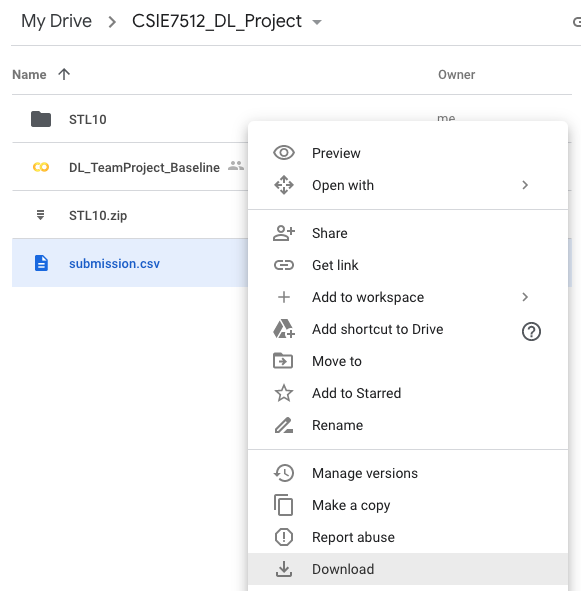

2. Go to our kaggle submission link and click `Submit Predicitions` button  
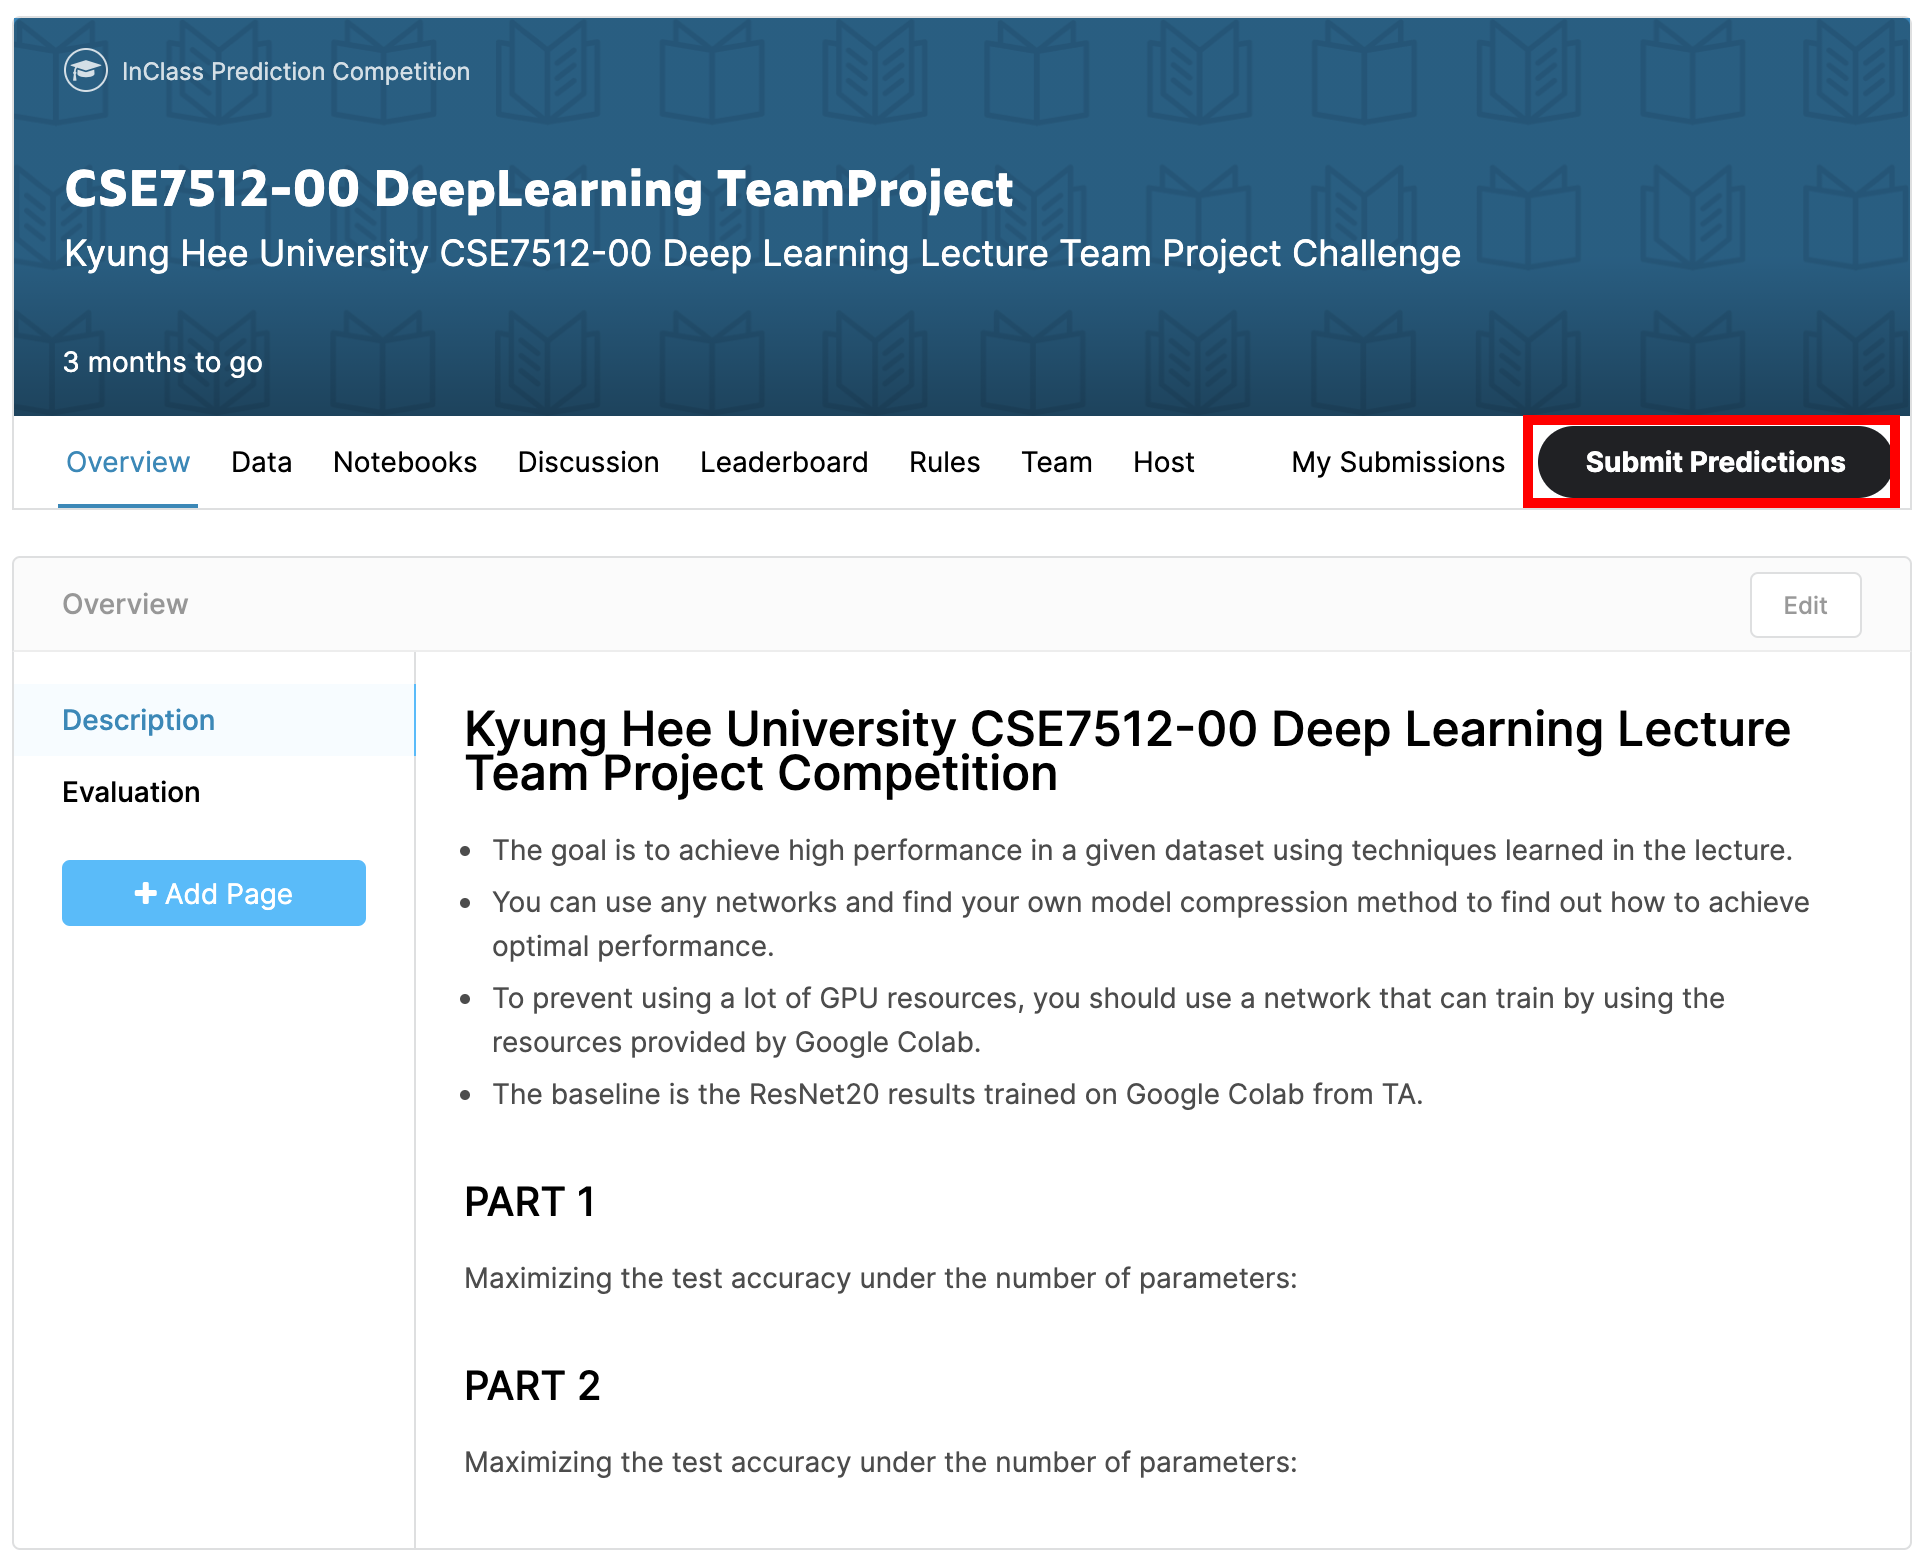

3. Upload Submission `csv` file and click `make submission` button  
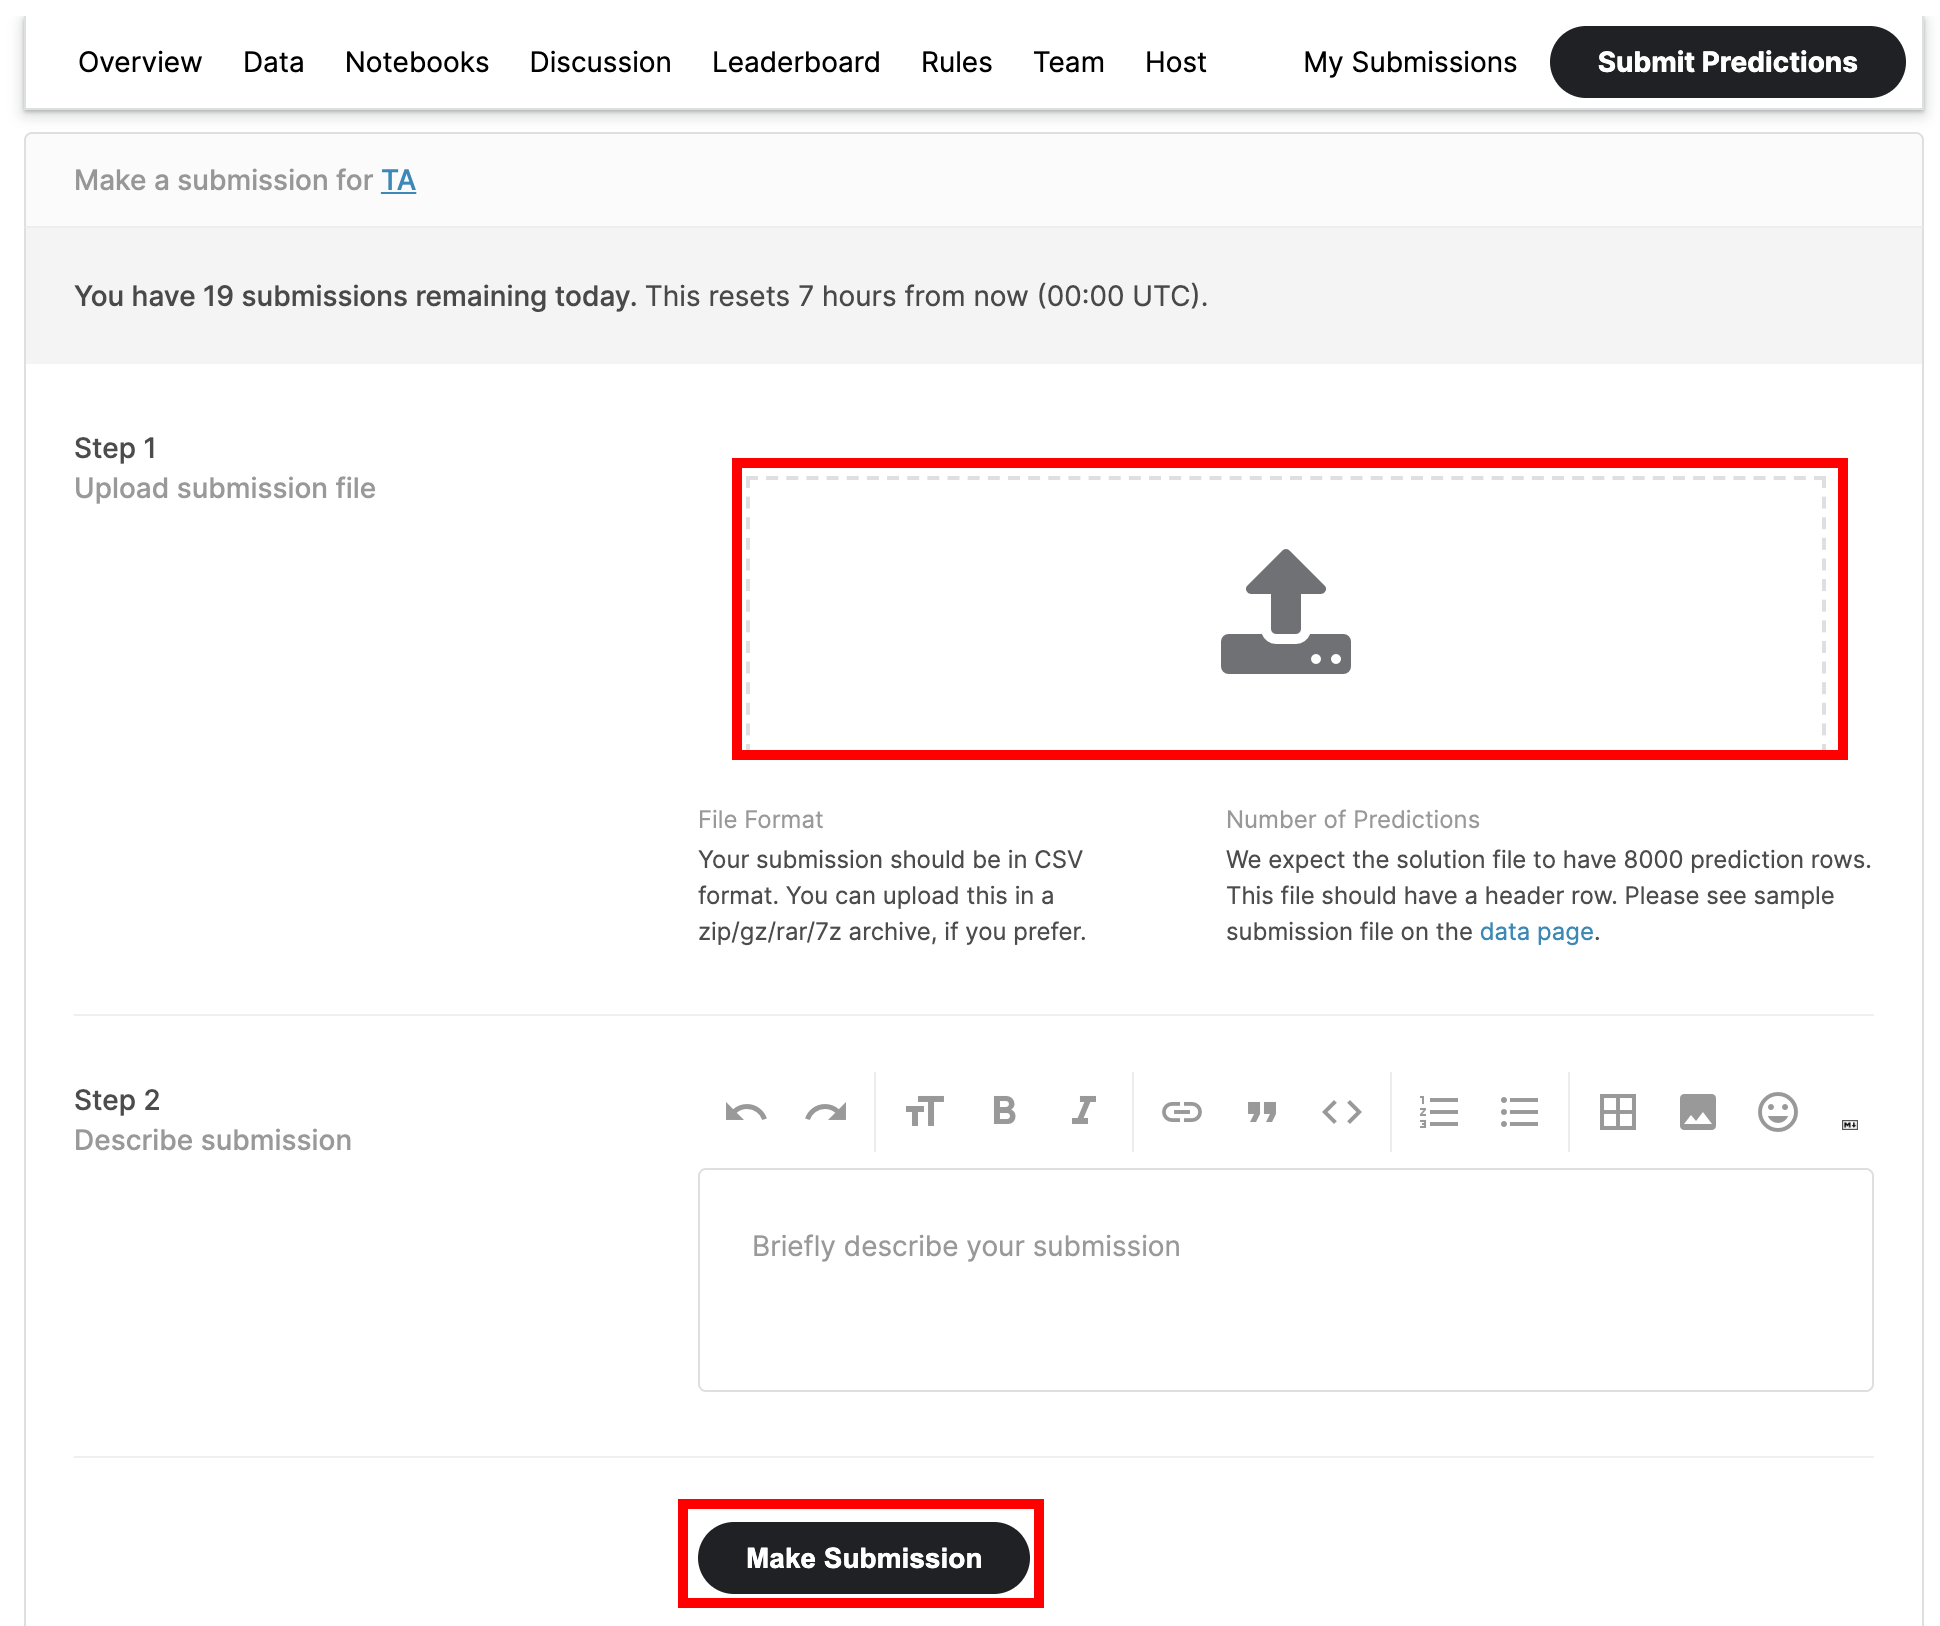

